<a href="https://colab.research.google.com/github/dickyadem/yoga-classification-with-resnet-18-using-pytorch/blob/main/Yoga_Resnet_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import os
import torch
import torchvision
import tarfile
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d oussamayousre/yogapose

 99% 205M/207M [00:01<00:00, 123MB/s]
100% 207M/207M [00:01<00:00, 137MB/s]


In [ ]:
!unzip '/content/yogapose.zip' -d '/content/yogapose'

Archive:  /content/yogapose.zip
  inflating: /content/yogapose/LICENSE  
  inflating: /content/yogapose/__notebook_source__.ipynb  
  inflating: /content/yogapose/movenet_thunder.tflite  
  inflating: /content/yogapose/test/chair/guy3_chair070.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair071.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair072.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair073.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair074.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair075.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair076.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair077.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair078.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair079.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair080.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair081.jpg  
  inflating: /content/yogapose/test/chair/guy3_chair082.jpg  
  infl

In [ ]:
data_dir ="/content/yogapose/yoga_poses/train"
data_dir

'/content/yogapose/yoga_poses/train'

In [ ]:
transformer = torchvision.transforms.Compose(
    [  
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
    ]
)
database = ImageFolder(data_dir, transform=transformer)

In [ ]:
database.classes

['chair', 'cobra', 'dog', 'tree', 'warrior']

In [ ]:
yoga_name_dict={'chair':0 ,
                  'cobra':1,
                  'dog':2 ,
                  'tree':3 ,
                  'warrior':4}

def encode_label(img_label):
    return yoga_name_dict[img_label] 

In [ ]:
yoga_label = {
    0: 'chair',
    1: 'cobra',
    2: 'dog',
    3: 'tree',
    4: 'warrior'
}

#Val_set and train_set

In [ ]:
validation_size = 500
training_size = len(database) - validation_size

In [ ]:
train_ds, val_ds_main = random_split(database,[training_size, validation_size])
val_ds, test_ds  = random_split(val_ds_main,[300, 200 ])
len(train_ds), len(val_ds)


(500, 300)

In [ ]:
batch_size=32

In [ ]:
train_dl = DataLoader(train_ds, batch_size , shuffle=True)
val_dl = DataLoader(val_ds,batch_size)
test_dl = DataLoader(test_ds, batch_size)

# 1. Training Image Classification 

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
 for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 224, 224])
out.shape: torch.Size([32, 5])
out[0]: tensor([-0.0052,  0.0011,  0.0200, -0.0450,  0.0452],
       grad_fn=<SelectBackward0>)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


# Get GPU up on running

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
device = get_default_device()

In [ ]:
device = get_default_device()
device

device(type='cuda')

# Training and Validation Dataset

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);


# 1. Transfer Learning using Restnet18 (Pre-trained) 

In [ ]:
class YogaModel18(ImageClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 5)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    

In [ ]:
model = to_device(YogaModel18(), device)
evaluate(model, val_dl)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

{'val_acc': 0.21562500298023224, 'val_loss': 1.6216890811920166}

In [ ]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
%%time
try3 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.3073, val_loss: 1.4005, val_acc: 0.4646
Epoch [1], train_loss: 1.1017, val_loss: 1.2245, val_acc: 0.6781
Epoch [2], train_loss: 1.0315, val_loss: 1.3487, val_acc: 0.5000
Epoch [3], train_loss: 0.9920, val_loss: 1.3642, val_acc: 0.4615
Epoch [4], train_loss: 0.9604, val_loss: 1.1061, val_acc: 0.7656
Epoch [5], train_loss: 0.9542, val_loss: 1.0486, val_acc: 0.8448
Epoch [6], train_loss: 0.9686, val_loss: 1.0898, val_acc: 0.7896
Epoch [7], train_loss: 0.9751, val_loss: 1.0683, val_acc: 0.8083
Epoch [8], train_loss: 0.9539, val_loss: 1.0308, val_acc: 0.8448
Epoch [9], train_loss: 0.9458, val_loss: 0.9732, val_acc: 0.9375
Epoch [10], train_loss: 0.9429, val_loss: 0.9972, val_acc: 0.9208
Epoch [11], train_loss: 0.9537, val_loss: 0.9544, val_acc: 0.9594
Epoch [12], train_loss: 0.9402, val_loss: 1.0051, val_acc: 0.8844
Epoch [13], train_loss: 0.9400, val_loss: 1.0411, val_acc: 0.8615
Epoch [14], train_loss: 0.9272, val_loss: 0.9326, val_acc: 0.9719
Epoch [15], train_lo

In [ ]:
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)


{'val_acc': 0.9553571343421936, 'val_loss': 0.9466593861579895}

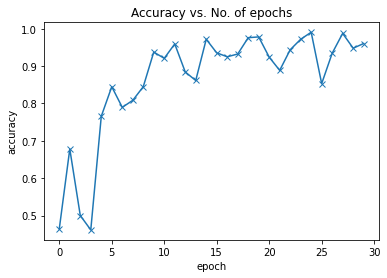

In [ ]:
def plot_accuracies(try3):
    accuracies = [x['val_acc'] for x in try3]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try3)

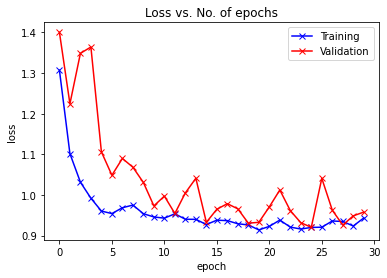

In [ ]:
def plot_losses(try3):
    train_losses = [x.get('train_loss') for x in try3]
    val_losses = [x['val_loss'] for x in try3]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try3)

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return yoga_label[preds[0].item()]

Label: chair , Predicted: cobra


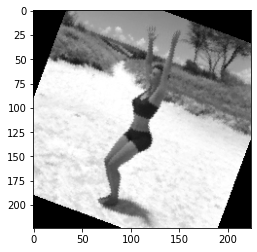

In [ ]:
img, label = test_ds[9]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, YogaModel18()))


Label: warrior , Predicted: warrior


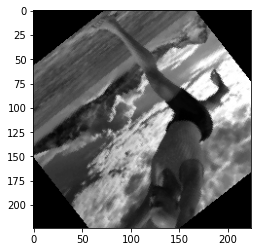

In [ ]:
img, label = test_ds[10]
plt.imshow(img[0], cmap='gray')
print('Label:', database.classes[label], ', Predicted:', predict_image(img, YogaModel18()))



In [ ]:
torch.save(model.state_dict(), 'Yoga.pth')